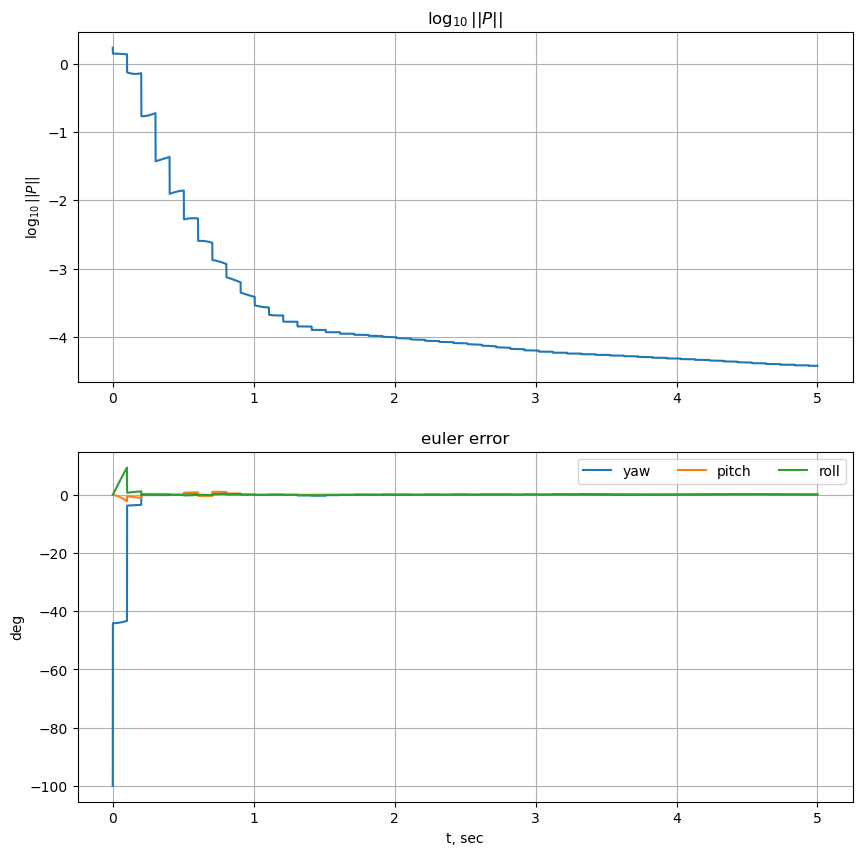

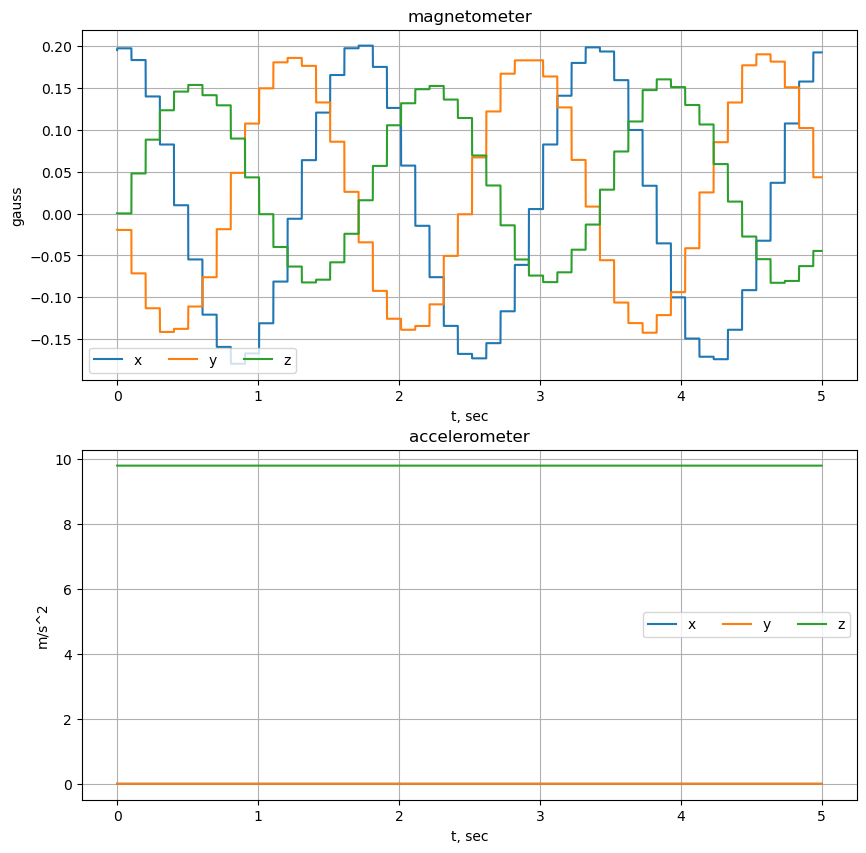

In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from att_estimator import simulate
import matplotlib.pyplot as plt

data = simulate()

P_norm = np.linalg.norm(data["P"][:, [0, 4, 8]], axis=1)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title("$\log_{10} ||P||$")
plt.ylabel("$\log_{10} ||P||$")
plt.plot(data["t"], np.log10(P_norm))
plt.grid()

plt.subplot(212)
plt.title("euler error")
plt.plot(data["t"], np.rad2deg(data["euler_error"]))
plt.legend(["yaw", "pitch", "roll"], loc="best", ncols=3)
plt.ylabel("deg")
plt.xlabel("t, sec")
plt.grid()


plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.title("magnetometer")
plt.plot(data["t"], data["y_mag"])
plt.legend(["x", "y", "z"], loc="best", ncols=3)
plt.ylabel("gauss")
plt.xlabel("t, sec")
plt.grid()

plt.subplot(212)
plt.title("accelerometer")
plt.plot(data["t"], data["y_accel"])
plt.legend(["x", "y", "z"], loc="best", ncols=3)
plt.ylabel("m/s^2")
plt.xlabel("t, sec")
plt.grid()